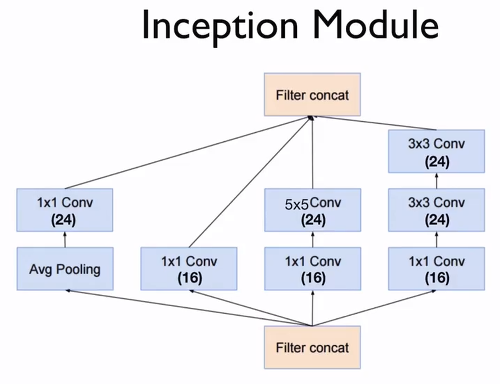

In [1]:
#import
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [7]:
#device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)
    
#data load
batch_size = 64
train_dset = datasets.MNIST(root = 'MNIST_data/',train = True, transform = transforms.ToTensor(), download = True)
test_dset = datasets.MNIST(root = 'MNIST_data/',train = False, transform = transforms.ToTensor(), download = True)
train_loader = torch.utils.data.DataLoader(dataset = train_dset, batch_size = batch_size, shuffle = True, drop_last = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dset, batch_size = batch_size, shuffle = True, drop_last = True)

In [8]:
#3x3과 5x5 Conv layer 생성을 위한 함수 정의
def Conv1x1(input_c,channel, stride = 1, padding = 0):
    return nn.Conv2d(input_c, channel, 1, stride = stride, padding = padding, bias = False)

def Conv3x3(input_c,channel, stride = 1, padding = 0):
    return nn.Conv2d(input_c, channel, 3, stride = stride, padding = padding, bias = False)

def Conv5x5(input_c,channel, stride = 1, padding = 0):
    return nn.Conv2d(input_c, channel, 5, stride = stride, padding = padding, bias = False)

#Inception Module
class InceptionModule(nn.Module):
    
    def __init__(self,input_c):
        super(InceptionModule,self).__init__()
        #pooling은 forward에서 바로 적용하면됨 (여기서 미리 정의해줄 필요 없다) 왜냐? 학습할 hyperparameter가 없음!
        
        #1라인 (branch_pool)
        self.Conv_12 = Conv1x1(input_c, 24)
        #2라인
        self.Conv_21 = Conv1x1(input_c,16)
        #3라인
        self.Conv_31 = Conv1x1(input_c,16)
        self.Conv_32 = Conv5x5(16,24,padding = 2) #padding : 2
        #4라인
        self.Conv_41 = Conv1x1(input_c,16)
        self.Conv_42 = Conv3x3(16,24,padding = 1)
        self.Conv_43 = Conv3x3(24,24,padding = 1)
        
    def forward(self,x):
        
        #1라인
        out1 = F.avg_pool2d(x,kernel_size = 3, stride = 1, padding = 1)
        out1 = self.Conv_12(out1)
        #2라인
        out2 = self.Conv_21(x)
        #3line
        out3 = self.Conv_31(x)
        out3 = self.Conv_32(out3)
        #4line
        out4 = self.Conv_41(x)
        out4 = self.Conv_42(out4)
        out4 = self.Conv_43(out4)
        
        #concatenation
        outputs = [out1,out2,out3,out4]
        return torch.cat(outputs, dim = 1)
        

# 전체 모델
Conv1(1,10,5)

pool + ReLU

INCEPTION_1

Conv2(88,20,5)

pool + ReLU

INCEPTION_2

Fully Connented

In [12]:
#전체 모델
class Net(nn.Module):
    
    def __init__(self):
        super(Net,self).__init__()
        
        self.conv1 = nn.Conv2d(1,10,kernel_size = 5)
        self.conv2 = nn.Conv2d(88,20,kernel_size = 5)
        
        self.max_pool = nn.MaxPool2d(2)
        self.fc = nn.Linear(1408,10)
        
        self.inception1 = InceptionModule(input_c = 10)
        self.inception2 = InceptionModule(input_c = 20)
        
    def forward(self,x):
        #N 추출
        in_size = x.size(0)
        
        #forward
        x = F.relu(self.max_pool(self.conv1(x)))
        x = self.inception1(x)
        x = F.relu(self.max_pool(self.conv2(x)))
        x = self.inception2(x)
        x = x.view(in_size,-1)
        x = self.fc(x)
        return F.log_softmax(x)
        
        

In [19]:
model = Net().to(device)

optimizer = optim.SGD(model.parameters(),lr = 0.01, momentum = 0.5)
criterion = nn.NLLLoss()  #모델이 softmax를 해서 뽑아주기때문에!

def train(epoch):
    model.train()
    avg_cost = 0
    total_batch = len(train_loader)
    for batch_idx, (data,target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        optimizer.zero_grad()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        avg_cost += loss/total_batch
        if batch_idx%50 ==0:
            print(epoch, avg_cost)


In [20]:
for epoch in range(1,10):
    train(epoch)

<ipython-input-12-0343edabad11>:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


1 tensor(0.0025, grad_fn=<AddBackward0>)
1 tensor(0.1251, grad_fn=<AddBackward0>)
1 tensor(0.2471, grad_fn=<AddBackward0>)
1 tensor(0.3667, grad_fn=<AddBackward0>)
1 tensor(0.4594, grad_fn=<AddBackward0>)
1 tensor(0.4991, grad_fn=<AddBackward0>)
1 tensor(0.5299, grad_fn=<AddBackward0>)
1 tensor(0.5543, grad_fn=<AddBackward0>)
1 tensor(0.5755, grad_fn=<AddBackward0>)
1 tensor(0.5963, grad_fn=<AddBackward0>)
1 tensor(0.6147, grad_fn=<AddBackward0>)
1 tensor(0.6321, grad_fn=<AddBackward0>)
1 tensor(0.6470, grad_fn=<AddBackward0>)
1 tensor(0.6616, grad_fn=<AddBackward0>)
1 tensor(0.6756, grad_fn=<AddBackward0>)
1 tensor(0.6883, grad_fn=<AddBackward0>)
1 tensor(0.7006, grad_fn=<AddBackward0>)
1 tensor(0.7124, grad_fn=<AddBackward0>)
1 tensor(0.7241, grad_fn=<AddBackward0>)
2 tensor(0.0001, grad_fn=<AddBackward0>)
2 tensor(0.0104, grad_fn=<AddBackward0>)
2 tensor(0.0206, grad_fn=<AddBackward0>)
2 tensor(0.0302, grad_fn=<AddBackward0>)
2 tensor(0.0399, grad_fn=<AddBackward0>)
2 tensor(0.0490,

In [33]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        # sum up batch loss
        test_loss += criterion(output, target).data.item()
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)/batch_size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [34]:
test()

<ipython-input-12-0343edabad11>:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Average loss: 0.0523, Accuracy: 9815/10000 (98%)

